In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/REED.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,5.76,6.05,5.76,5.90,5.90,159600
1,1/3/2013,5.93,6.10,5.83,6.06,6.06,73600
2,1/4/2013,6.02,6.50,6.02,6.47,6.47,110700
3,1/7/2013,6.50,6.50,6.24,6.37,6.37,71900
4,1/8/2013,6.44,6.45,6.33,6.37,6.37,45200


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -17.109998.3, cost: -35395.160156, total money: 9982.890002
epoch: 20, total rewards: -129.759993.3, cost: -34877.871094, total money: 9627.000007
epoch: 30, total rewards: -98.869993.3, cost: -34873.914062, total money: 9526.940007
epoch: 40, total rewards: -65.639996.3, cost: -35258.937500, total money: 9741.640005
epoch: 50, total rewards: -58.389995.3, cost: -35348.066406, total money: 9778.830006
epoch: 60, total rewards: -54.319998.3, cost: -35282.070312, total money: 9709.150002
epoch: 70, total rewards: -28.229999.3, cost: -35409.003906, total money: 9776.370002
epoch: 80, total rewards: -14.650000.3, cost: -35458.964844, total money: 9792.940000
epoch: 90, total rewards: -18.900001.3, cost: -35497.496094, total money: 9797.989999
epoch: 100, total rewards: -31.010002.3, cost: -35527.824219, total money: 9799.369999
epoch: 110, total rewards: -22.760004.3, cost: -35560.996094, total money: 9814.689997
epoch: 120, total rewards: -26.590005.3, cost: -355

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 5.690000, total balance 9994.310000
day 12, sell 1 unit at price 5.320000, investment -6.502634 %, total balance 9999.630000,
day 13: buy 1 unit at price 5.260000, total balance 9994.370000
day 14: buy 1 unit at price 5.270000, total balance 9989.100000
day 15: buy 1 unit at price 5.130000, total balance 9983.970000
day 17, sell 1 unit at price 5.420000, investment 3.041822 %, total balance 9989.390000,
day 18, sell 1 unit at price 5.410000, investment 2.656544 %, total balance 9994.800000,
day 19, sell 1 unit at price 5.730000, investment 11.695904 %, total balance 10000.530000,
day 21: buy 1 unit at price 5.930000, total balance 9994.600000
day 22: buy 1 unit at price 5.940000, total balance 9988.660000
day 23, sell 1 unit at price 5.880000, investment -0.843166 %, total balance 9994.540000,
day 26: buy 1 unit at price 5.590000, total balance 9988.950000
day 28, sell 1 unit at price 5.300000, investment -10.774408 %, total balance 9994.250000,
day 29: buy 1

day 323, sell 1 unit at price 5.200000, investment -8.611604 %, total balance 9963.370001,
day 324: buy 1 unit at price 5.250000, total balance 9958.120001
day 325: buy 1 unit at price 5.420000, total balance 9952.700001
day 326: buy 1 unit at price 5.460000, total balance 9947.240001
day 327, sell 1 unit at price 5.540000, investment -1.946905 %, total balance 9952.780001,
day 328: buy 1 unit at price 5.410000, total balance 9947.370001
day 329, sell 1 unit at price 5.420000, investment -5.078808 %, total balance 9952.790001,
day 333: buy 1 unit at price 5.460000, total balance 9947.330001
day 334, sell 1 unit at price 5.430000, investment -2.162169 %, total balance 9952.760001,
day 335, sell 1 unit at price 5.300000, investment -0.188319 %, total balance 9958.060001,
day 336: buy 1 unit at price 5.240000, total balance 9952.820001
day 337, sell 1 unit at price 5.280000, investment 0.380228 %, total balance 9958.100002,
day 339: buy 1 unit at price 5.160000, total balance 9952.940002


day 493, sell 1 unit at price 5.870000, investment -15.295815 %, total balance 9964.520002,
day 494: buy 1 unit at price 6.070000, total balance 9958.450001
day 495, sell 1 unit at price 6.060000, investment -12.427747 %, total balance 9964.510001,
day 497: buy 1 unit at price 6.190000, total balance 9958.320001
day 498: buy 1 unit at price 6.020000, total balance 9952.300001
day 499, sell 1 unit at price 6.110000, investment -16.870745 %, total balance 9958.410002,
day 500: buy 1 unit at price 6.100000, total balance 9952.310002
day 501, sell 1 unit at price 5.940000, investment -5.714288 %, total balance 9958.250002,
day 502: buy 1 unit at price 5.930000, total balance 9952.320002
day 503, sell 1 unit at price 5.910000, investment -5.591060 %, total balance 9958.230002,
day 504, sell 1 unit at price 5.900000, investment -4.530740 %, total balance 9964.130002,
day 507: buy 1 unit at price 5.590000, total balance 9958.540002
day 508, sell 1 unit at price 5.730000, investment -3.372678 

day 657, sell 1 unit at price 5.640000, investment -15.060241 %, total balance 9943.890001,
day 658: buy 1 unit at price 5.850000, total balance 9938.040001
day 659: buy 1 unit at price 6.050000, total balance 9931.990001
day 660: buy 1 unit at price 5.800000, total balance 9926.190001
day 661, sell 1 unit at price 5.510000, investment -16.641451 %, total balance 9931.700001,
day 662: buy 1 unit at price 5.370000, total balance 9926.330001
day 663: buy 1 unit at price 5.260000, total balance 9921.070001
day 664, sell 1 unit at price 5.050000, investment -20.970261 %, total balance 9926.120001,
day 666: buy 1 unit at price 5.070000, total balance 9921.050001
day 667, sell 1 unit at price 5.130000, investment -19.466245 %, total balance 9926.180001,
day 668: buy 1 unit at price 5.300000, total balance 9920.880001
day 670, sell 1 unit at price 5.300000, investment -14.927766 %, total balance 9926.180001,
day 671: buy 1 unit at price 5.190000, total balance 9920.990001
day 672: buy 1 unit 

day 819, sell 1 unit at price 4.660000, investment -1.894740 %, total balance 9928.090000,
day 822: buy 1 unit at price 4.850000, total balance 9923.240000
day 825: buy 1 unit at price 4.600000, total balance 9918.640001
day 826: buy 1 unit at price 4.710000, total balance 9913.930001
day 828: buy 1 unit at price 4.610000, total balance 9909.320000
day 832, sell 1 unit at price 4.530000, investment -3.205120 %, total balance 9913.850001,
day 833: buy 1 unit at price 4.650000, total balance 9909.200001
day 834: buy 1 unit at price 4.640000, total balance 9904.560001
day 835, sell 1 unit at price 4.530000, investment -2.580643 %, total balance 9909.090001,
day 837: buy 1 unit at price 4.510000, total balance 9904.580001
day 839: buy 1 unit at price 4.560000, total balance 9900.020001
day 841, sell 1 unit at price 4.500000, investment -4.051174 %, total balance 9904.520001,
day 844: buy 1 unit at price 4.500000, total balance 9900.020001
day 845: buy 1 unit at price 4.480000, total balanc

day 974: buy 1 unit at price 4.250000, total balance 9910.180000
day 978: buy 1 unit at price 4.250000, total balance 9905.930000
day 979, sell 1 unit at price 4.200000, investment 12.299460 %, total balance 9910.130000,
day 980: buy 1 unit at price 4.200000, total balance 9905.930000
day 982: buy 1 unit at price 4.100000, total balance 9901.830000
day 983, sell 1 unit at price 4.150000, investment 0.241551 %, total balance 9905.980000,
day 987, sell 1 unit at price 4.000000, investment -1.234573 %, total balance 9909.980000,
day 988: buy 1 unit at price 3.950000, total balance 9906.030000
day 989: buy 1 unit at price 4.000000, total balance 9902.030000
day 991: buy 1 unit at price 3.950000, total balance 9898.080000
day 992, sell 1 unit at price 3.950000, investment -6.839616 %, total balance 9902.030000,
day 993, sell 1 unit at price 4.000000, investment -5.882353 %, total balance 9906.030000,
day 995: buy 1 unit at price 3.900000, total balance 9902.130000
day 997: buy 1 unit at pri

day 1132: buy 1 unit at price 2.450000, total balance 9868.500000
day 1134: buy 1 unit at price 2.550000, total balance 9865.950001
day 1135: buy 1 unit at price 2.550000, total balance 9863.400001
day 1136, sell 1 unit at price 2.550000, investment -40.000001 %, total balance 9865.950001,
day 1137: buy 1 unit at price 2.350000, total balance 9863.600001
day 1139: buy 1 unit at price 2.400000, total balance 9861.200001
day 1140, sell 1 unit at price 2.350000, investment -45.977012 %, total balance 9863.550000,
day 1141: buy 1 unit at price 1.650000, total balance 9861.900000
day 1143, sell 1 unit at price 1.600000, investment -66.315789 %, total balance 9863.500000,
day 1145, sell 1 unit at price 1.600000, investment -57.333333 %, total balance 9865.100000,
day 1146: buy 1 unit at price 1.600000, total balance 9863.500000
day 1147: buy 1 unit at price 1.600000, total balance 9861.900000
day 1148, sell 1 unit at price 1.600000, investment -54.929576 %, total balance 9863.500000,
day 114

day 1314: buy 1 unit at price 1.650000, total balance 9852.190000
day 1315, sell 1 unit at price 1.650000, investment 0.000000 %, total balance 9853.840000,
day 1316, sell 1 unit at price 1.600000, investment -15.789471 %, total balance 9855.440000,
day 1317, sell 1 unit at price 1.650000, investment -8.333332 %, total balance 9857.090000,
day 1319: buy 1 unit at price 1.700000, total balance 9855.390000
day 1320: buy 1 unit at price 1.850000, total balance 9853.540000
day 1322, sell 1 unit at price 2.150000, investment 7.500005 %, total balance 9855.690000,
day 1323, sell 1 unit at price 2.250000, investment 18.421054 %, total balance 9857.940000,
day 1324, sell 1 unit at price 2.350000, investment 42.424239 %, total balance 9860.290000,
day 1325: buy 1 unit at price 2.250000, total balance 9858.040000
day 1326: buy 1 unit at price 2.200000, total balance 9855.840000
day 1327: buy 1 unit at price 2.150000, total balance 9853.690000
day 1329, sell 1 unit at price 2.250000, investment 6

day 1480: buy 1 unit at price 2.750000, total balance 9823.800000
day 1481: buy 1 unit at price 2.500000, total balance 9821.300000
day 1482, sell 1 unit at price 2.520000, investment -8.363637 %, total balance 9823.820000,
day 1483: buy 1 unit at price 2.520000, total balance 9821.300000
day 1486: buy 1 unit at price 2.450000, total balance 9818.850000
day 1487: buy 1 unit at price 2.410000, total balance 9816.439999
day 1489, sell 1 unit at price 2.540000, investment -15.333335 %, total balance 9818.979999,
day 1490: buy 1 unit at price 2.450000, total balance 9816.529999
day 1494: buy 1 unit at price 2.500000, total balance 9814.029999
day 1495, sell 1 unit at price 2.310000, investment -20.344832 %, total balance 9816.339999,
day 1497, sell 1 unit at price 2.350000, investment -18.965523 %, total balance 9818.689999,
day 1500, sell 1 unit at price 2.090000, investment -25.622777 %, total balance 9820.779999,
day 1504, sell 1 unit at price 2.120000, investment -28.135598 %, total ba

day 1656, sell 1 unit at price 3.190000, investment 49.765253 %, total balance 9812.169999,
day 1657: buy 1 unit at price 3.050000, total balance 9809.119999
day 1659: buy 1 unit at price 3.080000, total balance 9806.039999
day 1661, sell 1 unit at price 3.000000, investment 15.384620 %, total balance 9809.039999,
day 1663: buy 1 unit at price 3.010000, total balance 9806.029999
day 1664: buy 1 unit at price 3.000000, total balance 9803.029999
day 1665, sell 1 unit at price 2.120000, investment -14.170046 %, total balance 9805.149999,
day 1667, sell 1 unit at price 2.080000, investment -22.388064 %, total balance 9807.229999,
day 1668, sell 1 unit at price 1.990000, investment -25.187972 %, total balance 9809.219999,
day 1670: buy 1 unit at price 1.950000, total balance 9807.269999
day 1671, sell 1 unit at price 1.960000, investment -20.647773 %, total balance 9809.229999,
day 1672: buy 1 unit at price 1.950000, total balance 9807.279999
day 1674: buy 1 unit at price 1.750000, total ba

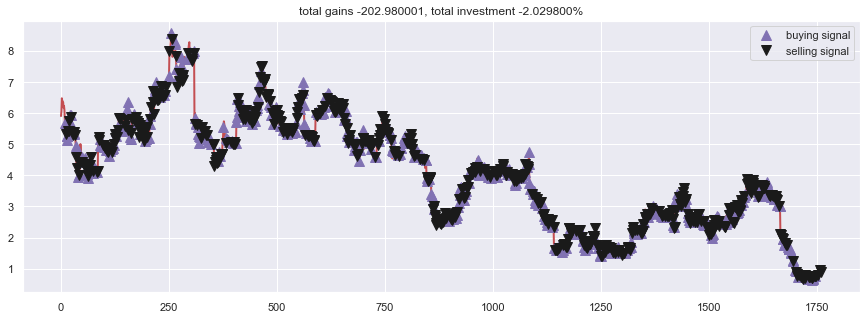

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()